In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.stats as st
import multiprocessing as mp

#Save
import json, h5py
import scipy.io as sio
import io_dict_to_hdf5 as ioh5

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

#User
import util
import plotting as usrplt
import decoding as dc

success_dict = {0: 'incorrect',1: 'correct', 2: 'abort'}

In [3]:
#Read in cross-validation parameters
modelstr = 'sticky-ARHMM_lag-1_dsf-2_kappa-1e+04_2021-04-04_2033'
# BaseDir = './results/sticky-ARHMM_lag-1_dsf-2_kappa-1e+07_2020-11-15_1437'
BaseDir = os.path.join('/srv/data/data0/dwyrick/projects/jumping_behavior/results/Last_5s/',modelstr)
with open(os.path.join(BaseDir,'ARHMM_hyperparameters.json')) as json_file:
    opt = json.load(json_file)
opt

{'save': 1,
 'RootDataDir': '/gpfs/projects/niell/nlab/Jumping/ARHMM/data/',
 'ResultsDir': '/gpfs/projects/niell/nlab/Jumping/ARHMM/results',
 'mID': 'all_mice',
 'downsample_factor': 2,
 'model_type': 'ARHMM',
 'transitions': 'sticky',
 'observations': 'autoregressive',
 'inputdriven': 0,
 'Kmin': 13,
 'Kmax': 16,
 'kappa': 10000.0,
 'AR_lags': 1,
 'MAP_threshold': 0.75,
 'EM_tolerance': 1e-06,
 'EM_iters': 200,
 'xval_type': 'K',
 'kXval': 2,
 'max_processes': 7,
 'SaveDirRoot': '/gpfs/projects/niell/nlab/Jumping/ARHMM/results/sticky-ARHMM_lag-1_dsf-2_kappa-1e+04_2021-04-04_2033',
 'cut': 5}

In [2]:
Ks = np.arange(6,17)
Ks

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [ ]:
ll_heldout = np.zeros((len(Ks),3),dtype=np.float64)
BIC_heldout = np.zeros((len(Ks),3),dtype=np.float64)
obs_dim = 6
for jj, K in enumerate(Ks):
    # Initial state distribution + A matrices + B matrices + covariance + transition probability matrix
    num_parameters = K + K*obs_dim*obs_dim + K*obs_dim + K*obs_dim*obs_dim + K*K
    print('{:02d}: '.format(K))
    KDir = os.path.join(BaseDir,'K-{:02d}'.format(K))

    #Get full model cross-validation
    fpath = glob(os.path.join(KDir,'fit_parameters*.h5'))[0]
    data = ioh5.load(fpath)
    tTest = data['tTest']; tTrain = data['tTrain']
    ll = data['ll_heldout']

    #Calculate number of timepoints 
    nTest = tTest*obs_dim; nTrain = tTrain*obs_dim
    ll_heldout[jj,-1] = ll/nTest

    #Calculate BIC
    BIC_heldout[jj,-1] = num_parameters*np.log(nTest) - 2*ll

    kfold_dirs = sorted(glob(os.path.join(KDir,'kFold_*')))
    for kk,kfold in enumerate(kfold_dirs):
        fpath = glob(os.path.join(kfold,'fit_parameters*.h5'))[0]
        data = ioh5.load(fpath)

        tTest = data['tTest']; tTrain = data['tTrain']
        ll = data['ll_heldout']
#         print('\t{}: {}\t{}'.format(kk,tTest,tTrain))

        #Calculate number of timepoints 
        nTest = tTest; nTrain = tTrain

        ll_heldout[jj,kk] = ll/nTest
        #Calculate BIC
        BIC_heldout[jj,kk] = num_parameters*np.log(nTest) - 2*ll

In [ ]:
#Stratify data per mice and per condition for kfolds
from sklearn.model_selection import StratifiedKFold
k_fold = StratifiedKFold(n_splits=2)
include = ['{}_D{}'.format(i,j) for i,j in zip(list(data_df['subject']),list(data_df['distance']))]
for iK, (train_indices, test_indices) in enumerate(k_fold.split(data_list,include)):
    data_train = [data_list[ii] for ii in train_indices]    
    data_test = [data_list[ii] for ii in test_indices]
        
    tTest = sum(map(len, data_test))
    tTrain = sum(map(len, data_train))
    print('\t{}: {}\t{}'.format(iK,tTest,tTrain))

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(Ks,np.mean(ll_heldout[:,:-1],axis=-1),'o-',color=usrplt.cc[0],label='\u03BA={:.0e}'.format(opt['kappa']))
ax.set_xlabel('Number of states'); ax.set_ylabel('Log-likelihood per data-point')
ax.legend()
plt.savefig(f'./plots/ll_{modelstr}.png')

In [4]:
data_list1, mask_list1, data_df1 = util.read_data('./data/variable_platform_data.h5',dsf=opt['downsample_factor'])
data_list2, mask_list2, data_df2 = util.read_data('./data/single_platform_data.h5',dsf=opt['downsample_factor'])

#Combine data
data_list = np.concatenate((data_list1,data_list2))
data_df = pd.concat((data_df1,data_df2)).reset_index()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [5]:
#Set abort trials to failure trials
# data_df.loc[data_df['success'] == 2,'success'] = 0

#Set "opto suture" trials where there was no optogenetics performed to "suture" trials
data_df.loc[(data_df['laser_trial'] == 'laser off') & (data_df['condition'] == 'opto suture'),'condition'] = 'suture'

#Print
data_df.head()

,index,expdate,subject,condition,platform,distance,jumpdist,success,laser_trial,jump_time,...,Side LEar y,Top LEar y,Side LEar likelihood,Top LEar likelihood,Side TakeFL x,Top TakeFL x,Side TakeFL y,Top TakeFL y,Side TakeFL likelihood,Top TakeFL likelihood
0,0,061920,J157BLT,control,2,8,-3.982283,2,laser off,125,...,"[423.72592347067524, 364.67165100973773, 305.6...","[408.64487500350447, 350.4616657749888, 292.19...","[0.9999992847442627, 0.9999996423721313, 0.999...","[0.9999997615814209, 0.9999998807907104, 0.999...","[343.8412719726563, 458.4371704101562, 573.033...","[314.5657470703125, 419.42099609375003, 524.27...","[447.1793585818351, 383.12674017363196, 319.07...","[399.84854478086413, 340.8283665582079, 281.80...","[0.999998927116394, 0.9999992847442627, 0.9999...","[0.022194653749465942, 0.013417750597000122, 0..."
1,1,061920,J157BLT,control,1,20,2.294397,2,laser off,222,...,"[431.3506579657288, 374.341929938385, 317.3332...","[408.56666509301635, 351.6943384328601, 294.74...","[0.9999973773956299, 0.9999958276748657, 0.999...","[0.9999992847442627, 0.9999996423721313, 0.999...","[343.52678222656255, 458.06650390625003, 572.6...","[312.7005615234375, 416.93408203125, 521.16760...","[445.4469291897769, 381.59209520540185, 317.73...","[402.9814164809759, 344.8621843032415, 286.742...","[0.9999996423721313, 0.9999996423721313, 0.999...","[0.04482194781303406, 0.06799852848052979, 0.0..."
2,2,061920,J157BLT,control,3,8,8.752227,1,laser off,355,...,"[404.79148060191767, 345.4358165394176, 286.00...","[358.79330694025214, 303.6803186590022, 248.71...","[0.9999998807907104, 0.9999998807907104, 0.999...","[0.9999997615814209, 0.9999997615814209, 0.999...","[343.5391479492188, 457.974072265625, 572.3549...","[314.574169921875, 419.43222656250003, 524.290...","[443.5941315622041, 379.59785470673535, 315.46...","[399.7992825594815, 341.9664090243253, 284.133...","[0.9999998807907104, 0.9999998211860657, 0.999...","[0.8656889796257019, 0.7850416302680969, 0.630..."
3,3,061920,J157BLT,control,1,12,11.868924,1,laser off,514,...,"[424.95687788606114, 367.8762260305924, 310.51...","[374.1019906658016, 317.9154855388485, 261.762...","[0.9999997615814209, 0.9999995231628418, 0.999...","[0.9999972581863403, 0.9999987483024597, 0.999...","[343.9951171875, 458.68979492187503, 573.36568...","[315.40451660156253, 420.53935546875005, 525.6...","[447.6375674742603, 383.7432437437916, 319.820...","[404.4565834542745, 346.74406514372765, 289.03...","[0.9999951720237732, 0.9999984502792358, 0.999...","[0.004946380853652954, 0.004948854446411133, 0..."
4,4,061920,J157BLT,control,2,12,4.958840,0,laser off,651,...,"[427.9628224442646, 367.8422169755146, 307.330...","[353.36177926623395, 297.7764826353745, 242.33...","[1.0, 0.9999998807907104, 0.9999995231628418, ...","[0.9999991655349731, 0.9999986886978149, 0.999...","[343.91730957031257, 458.74045410156253, 573.5...","[313.2942993164063, 417.3133544921875, 521.236...","[445.0932828081332, 380.99920321828944, 316.93...","[401.61066193700907, 344.0429373276341, 286.47...","[0.9999997615814209, 0.9999998807907104, 0.999...","[0.9386019706726074, 0.956940770149231, 0.9827..."


In [6]:
K = 6
SaveDir = os.path.join(BaseDir,'K-{:02d}'.format(K))
fname_sffx = 'sARHMM_lag-{}_K-{:02d}_dsf-{}_Kappa-{:.0e}'.format(opt['AR_lags'],K,opt['downsample_factor'],opt['kappa'])

#Load MAP sequence results
fpath = glob(os.path.join(SaveDir,'MAP_seqs*.h5'))[0]
trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


In [7]:
trMasks2 = []
tBins_removed = []
for iTrial, mapseq in enumerate(trMAPs):
    #Apply posterior probability threshold mask
    MAPcp = mapseq.copy()
    mask = trMasks[iTrial]
    MAPcp[~mask] = -1

    #Loop over states and NaN out that were less than 100ms (3 frames)
    for state in range(K):
        state_1hot = np.concatenate(([0],(np.array(MAPcp) == state).astype(int),[0]))
        state_trans = np.diff(state_1hot)
        state_ends = np.nonzero(state_trans == -1)[0]
        state_starts = np.nonzero(state_trans == +1)[0]
        state_durations = state_ends - state_starts

        #State was not used this trial
        if len(state_durations) == 0:
            continue
        
#         pdb.set_trace()
        #Loop over the individual state sequences and NaN out the short ones
        for iSeq, sd in enumerate(state_durations):
            if sd <= 2: #For the 2x dsf data, this amounts to 67ms
                MAPcp[slice(state_starts[iSeq],state_ends[iSeq])] = -1

    #Update mask
    mask2 = MAPcp != -1
    trMasks2.append(mask2)

    #See how much of a difference that made
    tBins_removed.append(np.sum(mask)-np.sum(mask2))
      
df_all = data_df.copy()        
df_all['trMAPs'] = trMAPs
df_all['trPosteriors'] = trPosteriors
df_all['trMasks'] = trMasks2 # note which version of masking you want

In [8]:
permutation = [1,3,5,2,4,0]

#Mask out state 0
for n, row in enumerate(df_all['trMasks']):
    row[df_all['trMAPs'][n]==0] = False
    
#Loop through each trial and permute state labels
for n, row in enumerate(df_all['trMAPs']):
    temp = row.copy()
    for m, state in enumerate(permutation):
        df_all['trMAPs'][n][temp==state] = m
    

## Compare binocular vs monocular trials during variable platform condition 
#### i.e. control vs suture
do it per distance
only success trials


In [193]:
### baseline (no opto) data & no RIS data
base_df = df_all.copy()
base_df = base_df[(base_df['condition']=='control') | (base_df['condition']=='suture')]
base_df = base_df[base_df['laser_trial']=='laser off']
base_df.reset_index(inplace=True,drop=True)

for key in base_df.keys():
    if ('Side' in key) | ('Top' in key):
        del base_df[key]

In [194]:
K = 6
lexical_TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=True)
TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=True,lexical=False)
TCMs_unnormalized = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=False)

TPM = np.exp(arhmm_params['transitions']['log_Ps'])


lexical_TCMs = lexical_TCMs[:,:(K-1),:(K-1)]
TCMs = TCMs[:,:(K-1),:(K-1)]
TCMs_unnormalized = TCMs_unnormalized[:,:(K-1),:(K-1)]



## Calculate state duration and state usage 
state_duration_list, state_startend_list, mean_state_durations, state_usage_pertrial, state_usage = util.get_state_durations(list(base_df['trMAPs']),list(base_df['trMasks']), K)

/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(699.8235294117648, 0.5, 'State i')

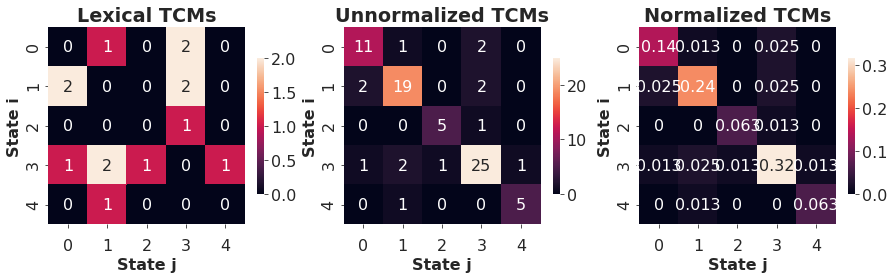

In [195]:
iTrial = 0
fig, axes = plt.subplots(1,3,figsize=(15,5))


#Create masks for diagonal
diag_mask = np.ones((K,K),dtype=bool)
diag_mask[np.diag_indices(K)] = False

ax = axes[0]
sns.heatmap(lexical_TCMs[iTrial],ax=ax,annot=True,square=True,cbar_kws={'shrink':0.5})

ax.set_title('Lexical TCMs')
ax.set_xlabel('State j'); ax.set_ylabel('State i')


ax = axes[1]

sns.heatmap(TCMs_unnormalized[iTrial],ax=ax,annot=True,square=True,cbar_kws={'shrink':0.5})

ax.set_title('Unnormalized TCMs')
ax.set_xlabel('State j'); ax.set_ylabel('State i')

ax = axes[2]
sns.heatmap(TCMs[iTrial],ax=ax,annot=True,square=True,cbar_kws={'shrink':0.5})

ax.set_title('Normalized TCMs')
ax.set_xlabel('State j'); ax.set_ylabel('State i')
    
    


In [196]:
indy_dict = base_df.groupby(['subject','ocular','distance','laser_trial','platform','success']).indices
conditions = np.unique(base_df['condition'])
mouse_IDs = np.unique(base_df['subject'])
distances = np.unique(base_df['distance'])
vision_types = np.unique(base_df['ocular'])

In [18]:
success_dict

{0: 'incorrect', 1: 'correct', 2: 'abort'}

In [198]:
K = lexical_TCMs.shape[-1]
K

5

In [ ]:
classifier = 'LDA'
method='L1O'
nKfold=5

mID = mouse_IDs[-1]
s = 1

pdfdoc = PdfPages('./plots/decoding3/btwvisiontype_normalized-CM_variable-platform_{}_{}.pdf'.format(method,classifier))
for ii, mID in enumerate(mouse_IDs):

    fig, axes = plt.subplots(2,4,figsize=(16,8))
    plt.suptitle('Decoding vision type for correct trials, variable platform with the normalized TCMs\n mouse {}; {} {} classifier'.format(mID,method,classifier))
    
    for ii, d in enumerate(distances[:-1]):
        ##Can we decode monocular vs binocular success trials within the same mouse/distance?
        indy_dict = base_df.groupby(['subject','ocular','distance','success']).indices

        #What is the minimum # of trials between these conditions
        nTrials_match = np.min([len(indy_dict[(mID,v,d,1)]) for v in vision_types])
        print(f'{nTrials_match} trials matched')

        #Get trial indices
        indy_list = []
        for v in vision_types:
            indy_tmp = indy_dict[(mID,v,d,1)].copy()
            #Take random subset of trials to match # of nTrials_match
            np.random.shuffle(indy_tmp)
            indy_list.append(indy_tmp[:nTrials_match])
        trial_indices = np.concatenate(indy_list)

        #Create predictors and labels
        X = TCMs[trial_indices].reshape(len(trial_indices),-1)
        Y = np.array(base_df.iloc[trial_indices]['ocular'])
        Y_sort = np.array(['{}_{}'.format(base_df.iloc[iT]['ocular'],base_df.iloc[iT]['platform']) for iT in trial_indices])

        # decoding analysis #, decoding_weights, decoding_weights_shf, decoding_weights_z
        confusion_mat, confusion_shf, confusion_z, decoding_weights, decoding_weights_z, decoding_weights_pvalues = dc.cross_validate(X,Y,Y_sort,clabels=vision_types,nKfold=nKfold,classifier=classifier,method=method)

        features = np.zeros((K,K))
        indy = np.where((decoding_weights_pvalues < 0.05) | (decoding_weights_pvalues > 0.95))
        for x,y in zip(indy[0],indy[1]):
            features[x,y] = 1
        
        #Plot decoding performance 
        title = 'd: {}, n: {}'.format(d,nTrials_match)
        dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=vision_types,ax=axes[0,ii],title=title,annot=False,clims=[0,0.6])
        
        #Plot the delta-TCM that resulted in such a confusion matri
        dX = np.mean(X[np.where(Y == vision_types[0])],axis=0).reshape((K,K)) - np.mean(X[np.where(Y == vision_types[1])],axis=0).reshape((K,K))
        
        ax = axes[1,ii]
        sns.heatmap(dX,ax=ax,annot=False,square=True,cbar_kws={'shrink':0.5},center=0)
        ax.set_title('delta-TCM')
        ax.set_xlabel('State j'); 
        if ii == 0: 
            ax.set_ylabel('State i')
        x = np.linspace(0, features.shape[0]-1, features.shape[0])+0.5
        y = np.linspace(0, features.shape[1]-1, features.shape[1])+0.5
        X, Y = np.meshgrid(x, y)
        ax.scatter(X,Y,marker='*',s=30*features, c='k')
    
    
#     plt.show()
#     pdb.set_trace()
    pdfdoc.savefig(fig)
    plt.close(fig)
pdfdoc.close()
#     plt.savefig('./plots/decoding2/btwvisiontype_fullTCM_variable-platform_{}_{}_{}.png'.format(mID,success_dict[s],classifier))

[213 213] trials matched


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.10148403052809349	0.11799437011223461	-0.016510339584141116


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[414 414] trials matched


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.10954929554783663	0.13636556060613966	-0.026816265058303028


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[261 261] trials matched


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.14447739354617123	0.14671817535790174	-0.002240781811730494


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[303 303] trials matched


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.1262453911704008	0.11827774070443789	0.007967650465962916


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[324 324] trials matched


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.11470792776969983	0.12239009537898048	-0.007682167609280621


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[321 321] trials matched


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.127292914896098	0.12683820024825393	0.00045471464784405634


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[261 261] trials matched


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.13508680010874619	0.14173612492184334	-0.0066493248130971485


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[306 306] trials matched


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.10573959563297818	0.1327703075326847	-0.027030711899706548


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


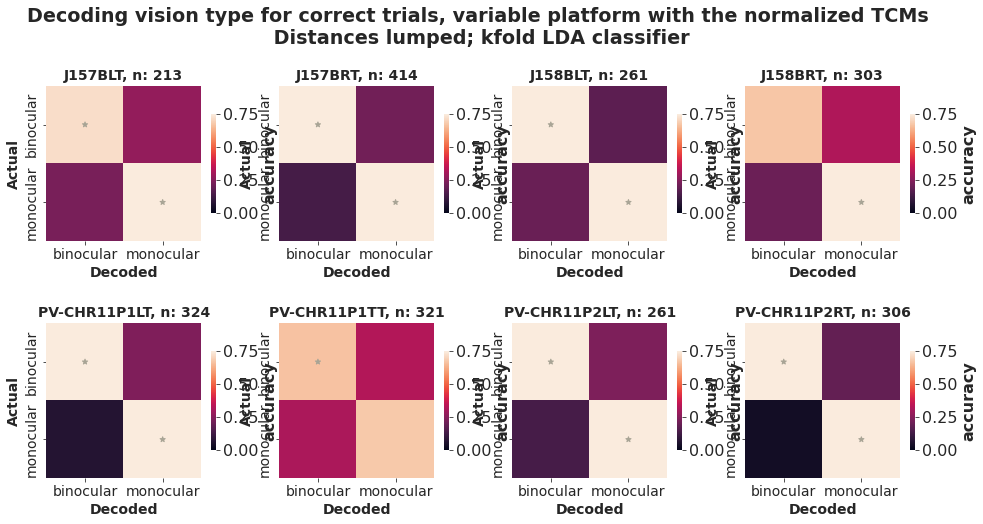

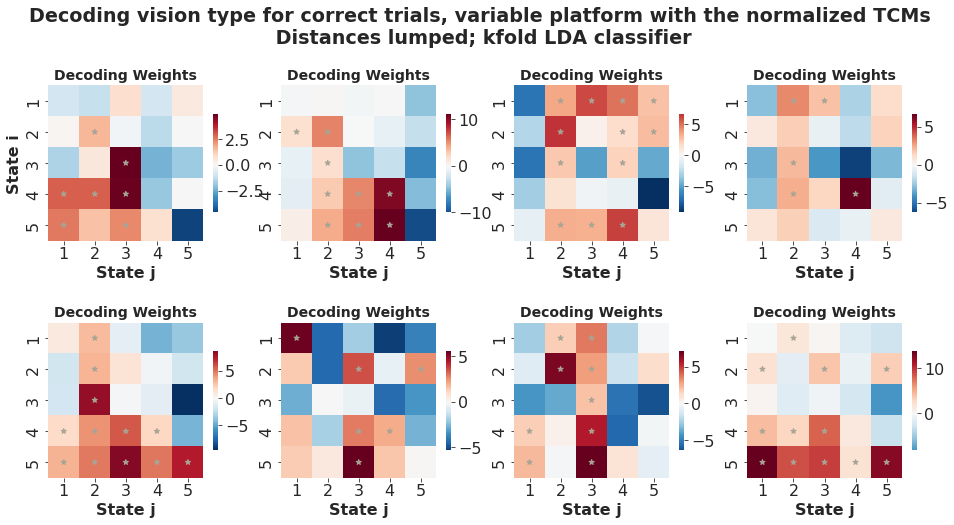

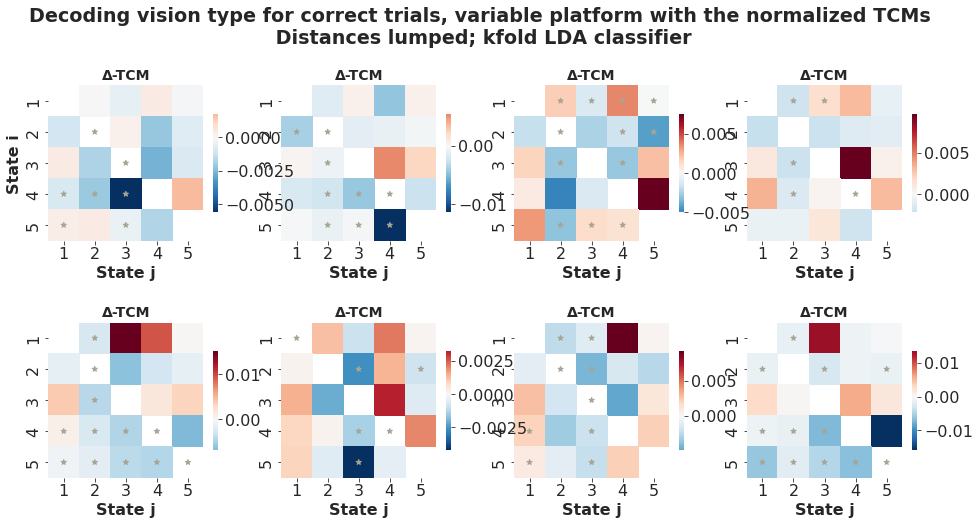

In [199]:
classifier = 'LDA'
method='kfold'

cm = np.zeros((len(mouse_IDs),2,2))
cm_z = np.zeros((len(mouse_IDs),2,2))

dw = np.zeros((len(mouse_IDs),5,5))
dw_z = np.zeros((len(mouse_IDs),5,5))

dTCM = np.zeros((len(mouse_IDs),5,5))
s = 1
p = 1

fig, axes = plt.subplots(2,4,figsize=(16,8))
plt.suptitle('Decoding vision type for correct trials, variable platform with the normalized TCMs\n Distances lumped; {} {} classifier'.format(method,classifier))


fig2, axes2 = plt.subplots(2,4,figsize=(16,8))
plt.suptitle('Decoding vision type for correct trials, variable platform with the normalized TCMs\n Distances lumped; {} {} classifier'.format(method,classifier))


fig3, axes3 = plt.subplots(2,4,figsize=(16,8))
plt.suptitle('Decoding vision type for correct trials, variable platform with the normalized TCMs\n Distances lumped; {} {} classifier'.format(method,classifier))
results = []
for ii, mID in enumerate(mouse_IDs):


    ##Can we decode monocular vs binocular success trials within the same mouse/distance?
    indy_dict = base_df.groupby(['subject','ocular','distance','success']).indices

    #What is the minimum # of trials between these conditions

    #Get trial indices
    indy_list = []
    for d in distances:
        for p in range(1,4):
            if ((mID,vision_types[0],d,s) not in indy_dict.keys()) | ((mID,vision_types[1],d,s) not in indy_dict.keys()):
                continue
            nTrials_match = np.min([len(indy_dict[(mID,v,d,s)]) for v in vision_types])
            for v in vision_types:
                indy_tmp = indy_dict[(mID,v,d,s)].copy()
                #Take random subset of trials to match # of nTrials_match
                np.random.shuffle(indy_tmp)
                indy_list.append(indy_tmp[:nTrials_match])
    trial_indices = np.concatenate(indy_list)
    
    
    #Create predictors and labels
    X = TCMs[trial_indices].reshape(len(trial_indices),-1)
    Y = np.array(base_df.iloc[trial_indices]['ocular'])
    Y_sort = np.array(['{}_{}_{}'.format(base_df.iloc[iT]['ocular'],base_df.iloc[iT]['platform'],base_df.iloc[iT]['distance']) for iT in trial_indices])
#         print(np.unique(Y_sort,return_counts=True))
    _,nTrials_match = np.unique(Y,return_counts=True)
    print(f'{nTrials_match} trials matched')
#     pdb.set_trace()
    # decoding analysis
    confusion_mat, confusion_shf, confusion_z, decoding_weights, decoding_weights_z, decoding_weights_pvalues = dc.cross_validate(X,Y,Y_sort,clabels=vision_types,nKfold=10,classifier=classifier,method=method)

#     results.append((confusion_mat, confusion_shf, confusion_z, decoding_weights, decoding_weights_z))
    #Plot decoding performance 
    title = '{}, n: {}'.format(mID,nTrials_match[0])
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=vision_types,ax=axes[ii//4,ii%4],title=title,annot=False,clims=[0,0.75])

    cm[ii] = confusion_mat
    cm_z[ii] = confusion_z

    dw[ii] = decoding_weights
    dw_z[ii] = decoding_weights_z
            
    #Plot the delta-TCM that resulted in such a confusion matri
    dX = np.mean(X[np.where(Y == vision_types[0])],axis=0).reshape((K,K)) - np.mean(X[np.where(Y == vision_types[1])],axis=0).reshape((K,K))

    dTCM[ii] = dX
    
    indy = np.diag_indices(K)
    mask = np.zeros((K,K),dtype=bool)
    mask[indy] = 1
    
    Xb = np.mean(X[np.where(Y == vision_types[0])],axis=0).reshape((K,K))
    Xm = np.mean(X[np.where(Y == vision_types[1])],axis=0).reshape((K,K))
    print('{}\t{}\t{}'.format(np.sum(Xb[~mask]),np.sum(Xm[~mask]),np.sum(dX[~mask])))
    
    features = np.zeros((K,K))
    indy = np.where((decoding_weights_pvalues < 0.05))
    for x,y in zip(indy[0],indy[1]):
        features[x,y] = 1
            
    ax = axes2[ii//4,ii%4]
    sns.heatmap(decoding_weights_z,ax=ax,annot=False,square=True,cbar_kws={'shrink':0.5},center=0,cmap='RdBu_r')
    ax.set_title('Decoding Weights',fontsize=14)
    ax.set_xlabel('State j'); 
    if ii == 0: 
        ax.set_ylabel('State i')
    x = np.linspace(0, features.shape[0]-1, features.shape[0])+0.5
    y = np.linspace(0, features.shape[1]-1, features.shape[1])+0.5
    X, Y = np.meshgrid(x, y)
    ax.scatter(X,Y,marker='*',s=30*features, c=usrplt.cc[-1])
    
    state_labels = np.arange(1,6)
    ax.set_yticks(np.arange(len(state_labels))+0.5)
    ax.set_xticks(np.arange(len(state_labels))+0.5)
    ax.set_yticklabels(state_labels,va="center",rotation=90,fontsize=16)
    ax.set_xticklabels(state_labels,va="center",rotation=0,fontsize=16) 
    
    
    ax = axes3[ii//4,ii%4]
    sns.heatmap(dX,ax=ax,mask=mask,annot=False,square=True,cbar_kws={'shrink':0.5},center=0,cmap='RdBu_r')
    ax.set_title('\u0394-TCM',fontsize=14)
    ax.set_xlabel('State j'); 
    if ii == 0: 
        ax.set_ylabel('State i')
    x = np.linspace(0, features.shape[0]-1, features.shape[0])+0.5
    y = np.linspace(0, features.shape[1]-1, features.shape[1])+0.5
    X, Y = np.meshgrid(x, y)
    ax.scatter(X,Y,marker='*',s=30*features, c=usrplt.cc[-1])
    
    state_labels = np.arange(1,6)
    ax.set_yticks(np.arange(len(state_labels))+0.5)
    ax.set_xticks(np.arange(len(state_labels))+0.5)
    ax.set_yticklabels(state_labels,va="center",rotation=90,fontsize=16)
    ax.set_xticklabels(state_labels,va="center",rotation=0,fontsize=16) 
    
#     plt.show()
#     pdb.set_trace()
    
fig.savefig('./plots/decoding3/btwvisiontype_dist-lump_normTCM_variable-platform_{}_{}.pdf'.format(method,classifier))
fig2.savefig('./plots/decoding3/btwvisiontype_dist-lump_normTCM_variable-platform_decoding-weights_{}_{}.pdf'.format(method,classifier))
fig3.savefig('./plots/decoding3/btwvisiontype_dist-lump_normTCM_variable-platform_delta-TCM_{}_{}.pdf'.format(method,classifier))

In [201]:
mdic = {"mouse_IDs":mouse_IDs, "confusion_matrices": cm,"confusion_matrices_z": cm_z, "decoding_weights": dw,"decoding_weights": dw_z,"deltaTCM":dTCM}
sio.savemat('./plots/decoding3/btwvisiontyp_normTCM_variable-platform_{}_{}.mat'.format(method,classifier),mdic)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


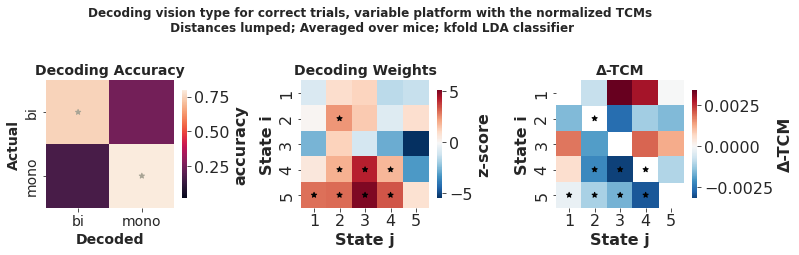

In [207]:
confusion_mat = np.mean(cm,axis=0)
confusion_z = np.mean(cm_z,axis=0)
decoding_weights = np.mean(dw,axis=0)
decoding_weights_z = np.mean(dw_z,axis=0)
#     results.append((confusion_mat, confusion_shf, confusion_z, decoding_weights, decoding_weights_z)

deltaTCM = np.mean(dTCM,axis=0)
decoding_weights_pvalues = st.norm.sf(decoding_weights_z)

features = np.zeros((K,K))
indy = np.where((decoding_weights_pvalues < 0.05))
for x,y in zip(indy[0],indy[1]):
    features[x,y] = 1

fig, axes = plt.subplots(1,3,figsize=(12,4),gridspec_kw={'wspace':0.6})

plt.suptitle('Decoding vision type for correct trials, variable platform with the normalized TCMs\n Distances lumped; Averaged over mice; {} {} classifier'.format(method,classifier),fontsize=12)



dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['bi','mono'],ax=axes[0],title='Decoding Accuracy',annot=False,cmap='rocket')#clims=[0,0.75])

ax = axes[1]
sns.heatmap(decoding_weights_z,ax=axes[1],annot=False,square=True,cbar_kws={'shrink':0.5,'label':'z-score'},center=0,cmap='RdBu_r')
ax.set_title('Decoding Weights',fontsize=14)
ax.set_ylabel('State i'); 
ax.set_xlabel('State j'); 

x = np.linspace(0, features.shape[0]-1, features.shape[0])+0.5
y = np.linspace(0, features.shape[1]-1, features.shape[1])+0.5
X, Y = np.meshgrid(x, y)
ax.scatter(X,Y,marker='*',s=30*features, c='k')

state_labels = np.arange(1,6)
ax.set_yticks(np.arange(len(state_labels))+0.5)
ax.set_xticks(np.arange(len(state_labels))+0.5)
ax.set_yticklabels(state_labels,va="center",rotation=90,fontsize=16)
ax.set_xticklabels(state_labels,va="center",rotation=0,fontsize=16) 


ax = axes[2]

sns.heatmap(deltaTCM,ax=axes[2],mask=mask,annot=False,square=True,cbar_kws={'shrink':0.5,'label':'\u0394-TCM'},center=0,cmap='RdBu_r')
ax.set_title('\u0394-TCM',fontsize=14)
ax.set_ylabel('State i'); 
ax.set_xlabel('State j'); 

x = np.linspace(0, features.shape[0]-1, features.shape[0])+0.5
y = np.linspace(0, features.shape[1]-1, features.shape[1])+0.5
X, Y = np.meshgrid(x, y)
ax.scatter(X,Y,marker='*',s=30*features, c='k')

state_labels = np.arange(1,6)
ax.set_yticks(np.arange(len(state_labels))+0.5)
ax.set_xticks(np.arange(len(state_labels))+0.5)
ax.set_yticklabels(state_labels,va="center",rotation=90,fontsize=16)
ax.set_xticklabels(state_labels,va="center",rotation=0,fontsize=16) 

plt.savefig('./plots/decoding3/btwvisiontype_avg-over-mice_normTCM_variable-platform_ROCKET_{}_{}.pdf'.format(method,classifier))

## Compare binocular vs monocular trials during single platform condition 
#### i.e. RIS control vs RIS opto suture
do it per distance
only success trials

In [52]:
np.unique(df_all['condition'])

array(['RIS control', 'RIS opto suture', 'control', 'opto suture',
       'suture'], dtype=object)

In [110]:
### baseline (no opto) data & no RIS data
base_df = df_all.copy()
base_df = base_df[(base_df['condition']=='RIS control') | (base_df['condition']=='RIS opto suture')]
base_df = base_df[base_df['laser_trial']=='laser off']
base_df.reset_index(inplace=True,drop=True)

for key in base_df.keys():
    if ('Side' in key) | ('Top' in key):
        del base_df[key]
        
np.unique(base_df['condition'])

array(['RIS control', 'RIS opto suture'], dtype=object)

In [111]:
K = 6
lexical_TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=True)
TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=True,lexical=False)
TCMs_unnormalized = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=False)

TPM = np.exp(arhmm_params['transitions']['log_Ps'])

lexical_TCMs = lexical_TCMs[:,:(K-1),:(K-1)]
TCMs = TCMs[:,:(K-1),:(K-1)]
TCMs_unnormalized = TCMs_unnormalized[:,:(K-1),:(K-1)]

K = TCMs.shape[-1]
## Calculate state duration and state usage 
state_duration_list, state_startend_list, mean_state_durations, state_usage_pertrial, state_usage = util.get_state_durations(list(base_df['trMAPs']),list(base_df['trMasks']), K)

In [112]:
indy_dict = base_df.groupby(['subject','ocular','distance','laser_trial','platform','success']).indices
conditions = np.unique(base_df['condition'])
mouse_IDs = np.unique(base_df['subject'])
distances = np.unique(base_df['distance'])
vision_types = np.unique(base_df['ocular'])
mouse_IDs

array(['J158BLT', 'J158BRT', 'PV-CHR11P1LT', 'PV-CHR11P1TT'], dtype=object)

In [86]:
K

5

[168 168] trials matched


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.13727891999656996	0.13406829613230695	0.0032106238642629816


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[171 171] trials matched


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.0934604977221857	0.12914001340083323	-0.03567951567864754


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[177 177] trials matched


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.07876355413741014	0.12978119387751427	-0.05101763974010413


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[81 81] trials matched


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.10601072571907294	0.11943395841652207	-0.013423232697449137


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


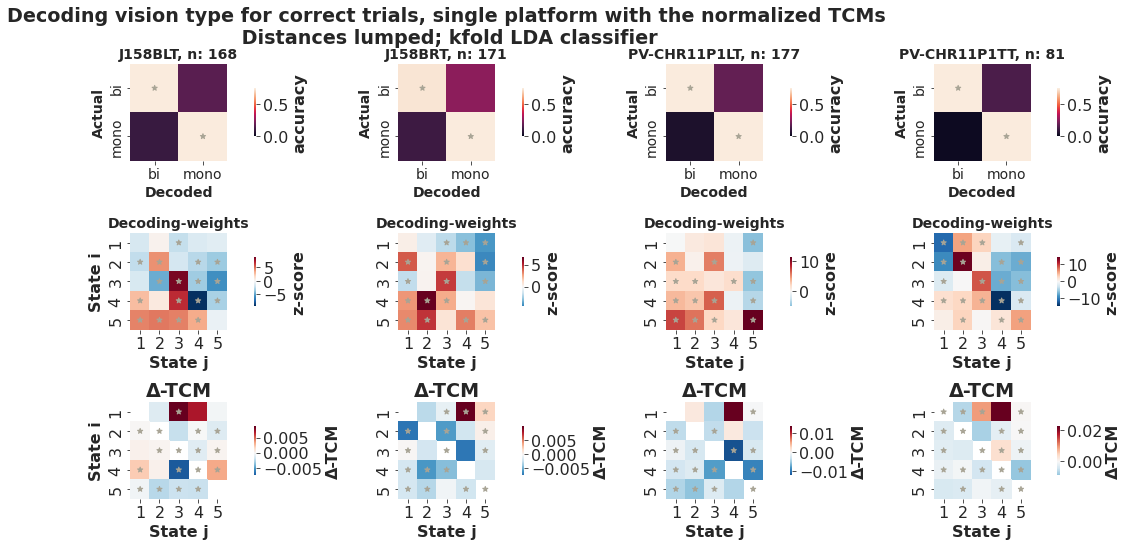

In [183]:
classifier = 'LDA'
method='kfold'

cm = np.zeros((len(mouse_IDs),2,2))
cm_z = np.zeros((len(mouse_IDs),2,2))

dw = np.zeros((len(mouse_IDs),5,5))
dw_z = np.zeros((len(mouse_IDs),5,5))

dTCM = np.zeros((len(mouse_IDs),5,5))

s = 1
p = 1
fig, axes = plt.subplots(3,4,figsize=(24,8),gridspec_kw={'wspace':-0.5,'hspace':0.75})

plt.suptitle('Decoding vision type for correct trials, single platform with the normalized TCMs\n Distances lumped; {} {} classifier'.format(method,classifier))

for ii, mID in enumerate(mouse_IDs):


    ##Can we decode monocular vs binocular success trials within the same mouse/distance?
    indy_dict = base_df.groupby(['subject','ocular','distance','success']).indices

    #What is the minimum # of trials between these conditions
    
    #Get trial indices
    indy_list = []
    for d in distances:
        for p in range(1,4):
            if ((mID,vision_types[0],d,s) not in indy_dict.keys()) | ((mID,vision_types[1],d,s) not in indy_dict.keys()):
                continue
            nTrials_match = np.min([len(indy_dict[(mID,v,d,s)]) for v in vision_types])
            for v in vision_types:
                indy_tmp = indy_dict[(mID,v,d,s)].copy()
                #Take random subset of trials to match # of nTrials_match
                np.random.shuffle(indy_tmp)
                indy_list.append(indy_tmp[:nTrials_match])
    trial_indices = np.concatenate(indy_list)
#     pdb.set_trace()
    
    #Create predictors and labels
    X = TCMs[trial_indices].reshape(len(trial_indices),-1)
    Y = np.array(base_df.iloc[trial_indices]['ocular'])
    Y_sort = np.array(['{}_{}_{}'.format(base_df.iloc[iT]['ocular'],base_df.iloc[iT]['platform'],base_df.iloc[iT]['distance']) for iT in trial_indices])
#         print(np.unique(Y_sort,return_counts=True))
    _,nTrials_match = np.unique(Y,return_counts=True)
    print(f'{nTrials_match} trials matched')
#     pdb.set_trace()
    # decoding analysis
    confusion_mat, confusion_shf, confusion_z, decoding_weights, decoding_weights_z, decoding_weights_pvalues = dc.cross_validate(X,Y,Y_sort,clabels=vision_types,nKfold=5,classifier=classifier,method=method)

    #Plot decoding performance 
    title = '{}, n: {}'.format(mID,nTrials_match[0])
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['bi','mono'],ax=axes[0,ii],title=title,annot=False,clims=[0,0.75])
    

    
    
    cm[ii] = confusion_mat
    cm_z[ii] = confusion_z

    dw[ii] = decoding_weights
    dw_z[ii] = decoding_weights_z
            
        
    features = np.zeros((K,K))
#     pvalues_loo = st.norm.sf(decoding_weights_z)
    indy = np.where((decoding_weights_pvalues < 0.05) | (decoding_weights_pvalues > 0.95))
    for x,y in zip(indy[0],indy[1]):
        features[x,y] = 1

    #Plot the delta-TCM that resulted in such a confusion matri
    dX = np.mean(X[np.where(Y == vision_types[0])],axis=0).reshape((K,K)) - np.mean(X[np.where(Y == vision_types[1])],axis=0).reshape((K,K))
    dTCM[ii] = dX
    
    indy = np.diag_indices(K)
    mask = np.zeros((K,K),dtype=bool)
    mask[indy] = 1
    
    Xb = np.mean(X[np.where(Y == vision_types[0])],axis=0).reshape((K,K))
    Xm = np.mean(X[np.where(Y == vision_types[1])],axis=0).reshape((K,K))
    print('{}\t{}\t{}'.format(np.sum(Xb[~mask]),np.sum(Xm[~mask]),np.sum(dX[~mask])))
    
    ax = axes[1,ii]
    sns.heatmap(decoding_weights_z,ax=ax,annot=False,square=True,cbar_kws={'shrink':0.5,'label':'z-score'},cmap='RdBu_r',center=0)
    ax.set_title('Decoding-weights',fontsize=14)
    ax.set_xlabel('State j'); 
    if ii == 0: 
        ax.set_ylabel('State i')
    x = np.linspace(0, features.shape[0]-1, features.shape[0])+0.5
    y = np.linspace(0, features.shape[1]-1, features.shape[1])+0.5
    X, Y = np.meshgrid(x, y)
    ax.scatter(X,Y,marker='*',s=30*features, c=usrplt.cc[-1])
    
    state_labels = np.arange(1,6)
    ax.set_yticks(np.arange(len(state_labels))+0.5)
    ax.set_xticks(np.arange(len(state_labels))+0.5)
    ax.set_yticklabels(state_labels,va="center",rotation=90,fontsize=16)
    ax.set_xticklabels(state_labels,va="center",rotation=0,fontsize=16) 
    
    
#     pdb.set_trace()
    ax = axes[2,ii]
#     indy = np.diag_indices(K)
#     mask = np.zeros((K,K),dtype=bool)
#     mask[indy] = 1
    
#     sns.heatmap(dX,ax=ax,annot=True,mask=~mask,square=True,cbar=False)#cbar_kws={'shrink':0.5,'label':'\u0394-TCM'},cmap='RdBu_r',center=0)
    
    sns.heatmap(dX,ax=ax,annot=False,mask=mask,square=True,cbar_kws={'shrink':0.5,'label':'\u0394-TCM'},cmap='RdBu_r',center=0)
    ax.set_title('\u0394-TCM')
    ax.set_xlabel('State j'); 
    if ii == 0: 
        ax.set_ylabel('State i')
    x = np.linspace(0, features.shape[0]-1, features.shape[0])+0.5
    y = np.linspace(0, features.shape[1]-1, features.shape[1])+0.5
    X, Y = np.meshgrid(x, y)
    ax.scatter(X,Y,marker='*',s=30*features, c=usrplt.cc[-1])

    
    state_labels = np.arange(1,6)
    ax.set_yticks(np.arange(len(state_labels))+0.5)
    ax.set_xticks(np.arange(len(state_labels))+0.5)
    ax.set_yticklabels(state_labels,va="center",rotation=90,fontsize=16)
    ax.set_xticklabels(state_labels,va="center",rotation=0,fontsize=16) 
    


#     plt.show()
#     pdb.set_trace()

plt.savefig('./plots/decoding3/btwvisiontype_dist-lump_normTCM_single-platform_ROCKET_{}_{}.pdf'.format(method,classifier))

In [189]:


mdic = {"mouse_IDs":mouse_IDs, "confusion_matrices": cm,"confusion_matrices_z": cm_z, "decoding_weights": dw,"decoding_weights": dw_z,"deltaTCM":dTCM}
sio.savemat('./plots/decoding3/btwvisiontyp_normTCM_single-platform_{}_{}.mat'.format(method,classifier),mdic)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


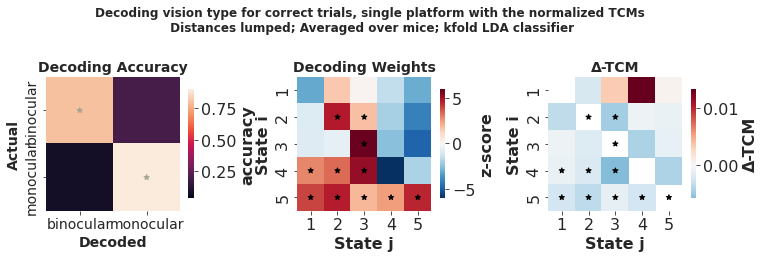

In [186]:
confusion_mat = np.mean(cm,axis=0)
confusion_z = np.mean(cm_z,axis=0)
decoding_weights = np.mean(dw,axis=0)
decoding_weights_z = np.mean(dw_z,axis=0)

deltaTCM = np.mean(dTCM,axis=0)
#     results.append((confusion_mat, confusion_shf, confusion_z, decoding_weights, decoding_weights_z)

decoding_weights_pvalues = st.norm.sf(decoding_weights_z)

features = np.zeros((K,K))
indy = np.where((decoding_weights_pvalues < 0.05))
for x,y in zip(indy[0],indy[1]):
    features[x,y] = 1

fig, axes = plt.subplots(1,3,figsize=(12,4),gridspec_kw={'wspace':0.5})

plt.suptitle('Decoding vision type for correct trials, single platform with the normalized TCMs\n Distances lumped; Averaged over mice; {} {} classifier'.format(method,classifier),fontsize=12)



dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=vision_types,ax=axes[0],title='Decoding Accuracy',annot=False,cmap='rocket')#clims=[0,0.75])

ax = axes[1]
sns.heatmap(decoding_weights_z,ax=axes[1],annot=False,square=True,cbar_kws={'shrink':0.5,'label':'z-score'},center=0,cmap='RdBu_r')
ax.set_title('Decoding Weights',fontsize=14)
ax.set_ylabel('State i'); 
ax.set_xlabel('State j'); 

x = np.linspace(0, features.shape[0]-1, features.shape[0])+0.5
y = np.linspace(0, features.shape[1]-1, features.shape[1])+0.5
X, Y = np.meshgrid(x, y)
ax.scatter(X,Y,marker='*',s=30*features, c='k')

state_labels = np.arange(1,6)
ax.set_yticks(np.arange(len(state_labels))+0.5)
ax.set_xticks(np.arange(len(state_labels))+0.5)
ax.set_yticklabels(state_labels,va="center",rotation=90,fontsize=16)
ax.set_xticklabels(state_labels,va="center",rotation=0,fontsize=16) 


ax = axes[2]

sns.heatmap(deltaTCM,ax=axes[2],mask=mask,annot=False,square=True,cbar_kws={'shrink':0.5,'label':'\u0394-TCM'},center=0,cmap='RdBu_r')
ax.set_title('\u0394-TCM',fontsize=14)
ax.set_ylabel('State i'); 
ax.set_xlabel('State j'); 

x = np.linspace(0, features.shape[0]-1, features.shape[0])+0.5
y = np.linspace(0, features.shape[1]-1, features.shape[1])+0.5
X, Y = np.meshgrid(x, y)
ax.scatter(X,Y,marker='*',s=30*features, c='k')

state_labels = np.arange(1,6)
ax.set_yticks(np.arange(len(state_labels))+0.5)
ax.set_xticks(np.arange(len(state_labels))+0.5)
ax.set_yticklabels(state_labels,va="center",rotation=90,fontsize=16)
ax.set_xticklabels(state_labels,va="center",rotation=0,fontsize=16) 

plt.savefig('./plots/decoding3/btwvisiontype_avg-over-mice_normTCM_single-platform_ROCKET_{}_{}.pdf'.format(method,classifier))

## Compare binocular vs monocular trials during single & variable platform condition 

do it per distance
only success trials

In [59]:
### baseline (no opto) data & no RIS data
base_df = df_all.copy()
base_df = base_df[(base_df['condition']=='RIS control') | (base_df['condition']=='RIS opto suture') | (base_df['condition']=='control') | (base_df['condition']=='suture')]
base_df = base_df[base_df['laser_trial']=='laser off']
base_df.reset_index(inplace=True,drop=True)

base_df['ptype'] = 'single'
base_df.loc[(base_df['condition']=='control') | (base_df['condition']=='suture'), 'ptype'] = 'variable'

nRows = base_df.shape[0]
trial_type = []
for index,row in base_df.iterrows():
    trial_type.append('{}-{}'.format(row['ptype'],row['ocular']))

base_df['trial_type'] = trial_type
for key in base_df.keys():
    if ('Side' in key) | ('Top' in key):
        del base_df[key]
        
conditions = np.unique(base_df['condition'])

In [60]:
base_df

,index,expdate,subject,condition,platform,distance,jumpdist,success,laser_trial,jump_time,trial,fps,ocular,trMAPs,trPosteriors,trMasks,ptype,trial_type
0,0,061920,J157BLT,control,2,8,-3.982283,2,laser off,125,1,60,binocular,"[2, 2, 2, 2, 4, 3, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[[0.0005776756546193978, 0.4112329337583417, 0...","[False, False, False, False, False, False, Tru...",variable,variable-binocular
1,1,061920,J157BLT,control,1,20,2.294397,2,laser off,222,2,60,binocular,"[4, 4, 4, 4, 4, 4, 4, 3, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0003379402401162872, 0.06956132132579314, ...","[False, True, True, True, True, True, True, Fa...",variable,variable-binocular
2,2,061920,J157BLT,control,3,8,8.752227,1,laser off,355,3,60,binocular,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, ...","[[6.799089904620362e-05, 0.30715664519927477, ...","[False, True, True, True, True, True, True, Tr...",variable,variable-binocular
3,3,061920,J157BLT,control,1,12,11.868924,1,laser off,514,4,60,binocular,"[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[[0.0025560465294300967, 0.9672454720895932, 0...","[True, True, True, True, True, True, True, Tru...",variable,variable-binocular
4,4,061920,J157BLT,control,2,12,4.958840,0,laser off,651,5,60,binocular,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, ...","[[0.00026205604161355536, 0.3589347519554482, ...","[False, True, True, True, True, True, True, Tr...",variable,variable-binocular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5909,2045,022021,PV-CHR11P1TT,RIS opto suture,1,8,4.020444,1,laser off,1719,13,60,monocular,"[3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, ...","[[4.8054698496186216e-05, 0.12161250140259505,...","[False, True, True, True, False, True, True, T...",single,single-monocular
5910,2046,022021,PV-CHR11P1TT,RIS opto suture,1,24,0.607811,2,laser off,1910,14,60,monocular,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.02161821819552265, 0.15986733176988102, 0....","[True, True, True, True, True, True, True, Tru...",single,single-monocular
5911,2048,022021,PV-CHR11P1TT,RIS opto suture,1,8,3.227044,1,laser off,2085,16,60,monocular,"[0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 2, ...","[[0.0025443333208913267, 0.9674304387675043, 0...","[False, False, False, True, True, True, False,...",single,single-monocular
5912,2050,022021,PV-CHR11P1TT,RIS opto suture,1,12,7.960352,1,laser off,2316,18,60,monocular,"[4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0003369380044915807, 0.0721177435000796, 0...","[False, False, False, False, True, True, True,...",single,single-monocular


In [34]:
lexical_TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=True)
TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=True,lexical=False)
TCMs_unnormalized = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=False)

TPM = np.exp(arhmm_params['transitions']['log_Ps'])


## Calculate state duration and state usage 
state_duration_list, state_startend_list, mean_state_durations, state_usage_pertrial, state_usage = util.get_state_durations(list(base_df['trMAPs']),list(base_df['trMasks']), K)

/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
trial_types = np.unique(base_df['trial_type'])
conditions = np.unique(base_df['condition'])
mouse_IDs = np.unique(base_df['subject'])
distances = np.unique(base_df['distance'])
vision_types = np.unique(base_df['ocular'])

In [36]:
mouse_IDs = ['J158BLT', 'J158BRT', 'PV-CHR11P1LT', 'PV-CHR11P1TT']

[168 168 168 168] trials matched
[171 171 171 171] trials matched
[162 162 162 162] trials matched
[81 81 81 81] trials matched


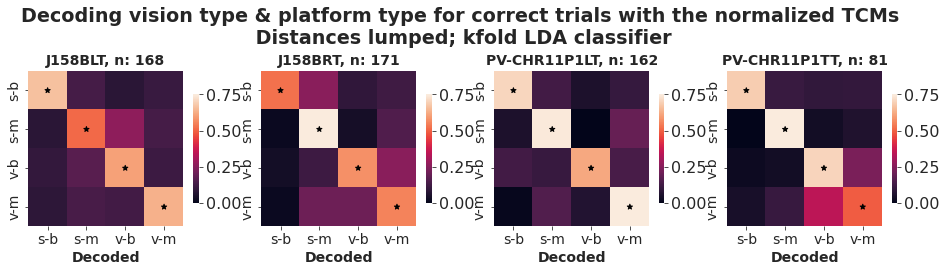

In [41]:
classifier = 'LDA'
method='kfold'

s = 1
p = 1
fig, axes = plt.subplots(1,4,figsize=(16,4))

plt.suptitle('Decoding vision type & platform type for correct trials with the normalized TCMs\n Distances lumped; {} {} classifier'.format(method,classifier),y=0.995)

for ii, mID in enumerate(mouse_IDs):


    ##Can we decode monocular vs binocular success trials within the same mouse/distance?
    indy_dict = base_df.groupby(['subject','trial_type','distance','success']).indices

    #What is the minimum # of trials between these conditions
    
    #Get trial indices
    indy_list = []
    nTrials_match = []
    for d in distances:
        for p in range(1,4):

                
            if ((mID,trial_types[0],d,s) not in indy_dict.keys()) | ((mID,trial_types[1],d,s) not in indy_dict.keys()) | ((mID,trial_types[2],d,s) not in indy_dict.keys()) | ((mID,trial_types[3],d,s) not in indy_dict.keys()):
                continue
            nTrials_match = np.min([len(indy_dict[(mID,c,d,s)]) for c in trial_types])
            for c in trial_types:
                indy_tmp = indy_dict[(mID,c,d,s)].copy()
                #Take random subset of trials to match # of nTrials_match
                np.random.shuffle(indy_tmp)
                indy_list.append(indy_tmp[:nTrials_match])

    trial_indices = np.concatenate(indy_list)
#     pdb.set_trace()
    
    #Create predictors and labels
    X = TCMs[trial_indices].reshape(len(trial_indices),-1)
    Y = np.array(base_df.iloc[trial_indices]['trial_type'])
    Y_sort = np.array(['{}_{}_{}'.format(base_df.iloc[iT]['trial_type'],base_df.iloc[iT]['platform'],base_df.iloc[iT]['distance']) for iT in trial_indices])
#         print(np.unique(Y_sort,return_counts=True))
    _,nTrials_match = np.unique(Y,return_counts=True)
    print(f'{nTrials_match} trials matched')
#     pdb.set_trace()
    # decoding analysis
    confusion_mat, confusion_shf, confusion_z, decoding_weights, decoding_weights_z = dc.cross_validate(X,Y,Y_sort,clabels=trial_types,nKfold=5,classifier=classifier,method=method)

    #Plot decoding performance 
    title = '{}, n: {}'.format(mID,nTrials_match[0])
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=trial_types_labels,ax=axes[ii],title=title,annot=False,clims=[0,0.75])

plt.savefig('./plots/decoding2/btwvisiontype-and-ptype_dist-lump_normTCM_{}_{}.pdf'.format(method,classifier))

In [38]:
trial_types_labels = ['s-b','s-m','v-b','v-m']

## Compare laser-on vs laser-off trials during variable platform condition 

do it per distance
only success trials

In [108]:
### baseline (no opto) data & no RIS data
base_df = df_all.copy()
base_df = base_df[(base_df['condition']=='opto suture') | (base_df['condition']=='suture')]
base_df = base_df[base_df['ocular']=='monocular']
base_df.reset_index(inplace=True,drop=True)

base_df['ptype'] = 'variable'

trial_type = []
for index,row in base_df.iterrows():
    laser_str = row['laser_trial']
    laser_str = laser_str.replace(' ','-')
    
    if laser_str == 'laser-off':
        trial_type.append(0)
    else:
        trial_type.append(1)
#     trial_type.append('{}_{}'.format(row['ptype'],laser_str))

base_df['trial_type'] = trial_type
for key in base_df.keys():
    if ('Side' in key) | ('Top' in key):
        del base_df[key]
        
base_df

,index,expdate,subject,condition,platform,distance,jumpdist,success,laser_trial,jump_time,trial,fps,ocular,trMAPs,trPosteriors,trMasks,ptype,trial_type
0,2971,071820,J157BLT,suture,3,8,10.317914,1,laser off,311,1,60,monocular,"[3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, ...","[[1.9802110175678525e-05, 0.15098861098594712,...","[False, False, False, True, True, True, False,...",variable,0
1,2972,071820,J157BLT,suture,2,12,12.731243,1,laser off,463,2,60,monocular,"[2, 2, 2, 2, 4, 4, 4, 4, 4, 3, 3, 3, 1, 1, 2, ...","[[0.00023141538403836318, 0.3507282915116824, ...","[False, True, True, True, True, True, True, Tr...",variable,0
2,2973,071820,J157BLT,suture,2,8,10.132664,1,laser off,562,3,60,monocular,"[3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, ...","[[0.003128414461116978, 0.16633028987103568, 0...","[False, False, False, True, True, True, True, ...",variable,0
3,2974,071820,J157BLT,suture,2,16,9.752289,0,laser off,690,4,60,monocular,"[2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 2, 2, 2, ...","[[9.208680662875985e-05, 0.3134103604623716, 0...","[False, True, True, True, True, True, True, Tr...",variable,0
4,2975,071820,J157BLT,suture,3,12,13.253958,1,laser off,732,5,60,monocular,"[4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 3, 3, 3, ...","[[0.00033799273430716776, 0.06965128190882267,...","[False, True, True, True, True, True, True, Tr...",variable,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,4305,072420,PV-CHR11P2RT,suture,1,24,-1.551333,2,laser off,1571,20,60,monocular,"[0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, ...","[[0.006012342090861082, 0.5969305235761315, 0....","[False, False, False, True, True, True, True, ...",variable,0
1335,4306,072420,PV-CHR11P2RT,suture,2,24,20.971580,1,laser off,1597,21,60,monocular,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 0, 0, ...","[[0.00033465886437030254, 0.07227932190392906,...","[False, True, True, True, True, True, True, Fa...",variable,0
1336,4307,072420,PV-CHR11P2RT,suture,2,20,15.139364,0,laser off,1697,22,60,monocular,"[0, 0, 0, 0, 0, 0, 4, 4, 4, 2, 2, 2, 2, 2, 3, ...","[[0.002305868070805779, 0.8923281288087326, 0....","[True, True, True, True, True, True, True, Tru...",variable,0
1337,4308,072420,PV-CHR11P2RT,suture,1,20,20.029950,1,laser off,1739,23,60,monocular,"[3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 2, 2, ...","[[9.939546628231839e-05, 0.12657494802376823, ...","[False, False, False, True, True, True, True, ...",variable,0


In [109]:
lexical_TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=True)
TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=True,lexical=False)
TCMs_unnormalized = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=False)

TPM = np.exp(arhmm_params['transitions']['log_Ps'])


## Calculate state duration and state usage 
state_duration_list, state_startend_list, mean_state_durations, state_usage_pertrial, state_usage = util.get_state_durations(list(base_df['trMAPs']),list(base_df['trMasks']), K)

/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: need at least one array to concatenate

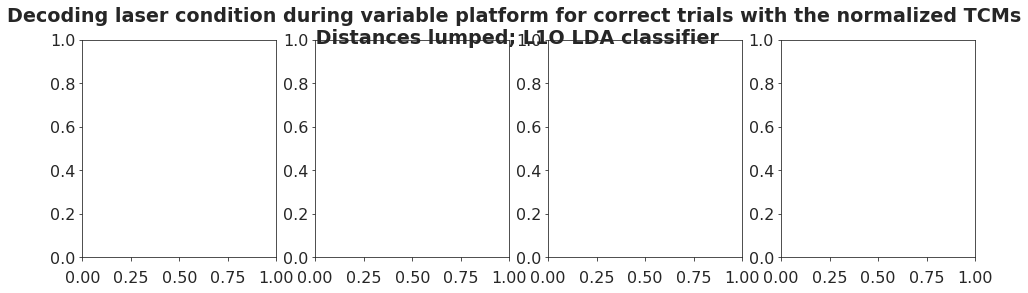

In [110]:
classifier = 'LDA'
method='L1O'
trial_types_labels = [0,1]
s = 1
p = 1
fig, axes = plt.subplots(1,4,figsize=(16,4))

plt.suptitle('Decoding laser condition during variable platform for correct trials with the normalized TCMs\n Distances lumped; {} {} classifier'.format(method,classifier),y=0.995)

for ii, mID in enumerate(mouse_IDs):


    ##Can we decode monocular vs binocular success trials within the same mouse/distance?
    indy_dict = base_df.groupby(['subject','trial_type','distance','success']).indices

    #What is the minimum # of trials between these conditions
    
    #Get trial indices
    indy_list = []
    nTrials_match = []
    for d in distances:
        for p in range(1,4):
            if ((mID,trial_types[0],d,s) not in indy_dict.keys()) | ((mID,trial_types[1],d,s) not in indy_dict.keys()):
                continue
            nTrials_match = np.min([len(indy_dict[(mID,c,d,s)]) for c in trial_types])
            for c in trial_types:
                indy_tmp = indy_dict[(mID,c,d,s)].copy()
                #Take random subset of trials to match # of nTrials_match
                np.random.shuffle(indy_tmp)
                indy_list.append(indy_tmp[:nTrials_match])

    trial_indices = np.concatenate(indy_list)
#     pdb.set_trace()
    
    #Create predictors and labels
    X = TCMs[trial_indices].reshape(len(trial_indices),-1)
    Y = np.array(base_df.iloc[trial_indices]['trial_type'])
    Y_sort = np.array(['{}_{}_{}'.format(base_df.iloc[iT]['trial_type'],base_df.iloc[iT]['platform'],base_df.iloc[iT]['distance']) for iT in trial_indices])
#         print(np.unique(Y_sort,return_counts=True))
    _,nTrials_match = np.unique(Y,return_counts=True)
    print(f'{nTrials_match} trials matched')
#     pdb.set_trace()
    # decoding analysis
    confusion_mat, confusion_shf, confusion_z, decoding_weights, decoding_weights_z = dc.cross_validate(X,Y,Y_sort,clabels=trial_types,nKfold=5,classifier=classifier,method=method)

    #Plot decoding performance 
    title = '{}, n: {}'.format(mID,nTrials_match[0])
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=trial_types_labels,ax=axes[ii],title=title,annot=False,clims=[0,0.75])

plt.savefig('./plots/decoding2/btwlaser_dist-lump_normTCM_variable-platform_{}_{}.pdf'.format(method,classifier))

## Compare laser-on vs laser-off trials during single platform condition 

do it per distance
only success trials

In [93]:
### baseline (no opto) data & no RIS data
base_df = df_all.copy()
base_df = base_df[(base_df['condition']=='RIS opto suture')]
base_df = base_df[base_df['ocular']=='monocular']
base_df.reset_index(inplace=True,drop=True)

base_df['ptype'] = 'single'

trial_type = []
for index,row in base_df.iterrows():
    laser_str = row['laser_trial']
    laser_str = laser_str.replace(' ','-')
#     trial_type.append('{}_{}'.format(row['ptype'],laser_str))
    
    
    if laser_str == 'laser-off':
        trial_type.append(0)
    else:
        trial_type.append(1)

base_df['trial_type'] = trial_type
for key in base_df.keys():
    if ('Side' in key) | ('Top' in key):
        del base_df[key]
        
base_df

,index,expdate,subject,condition,platform,distance,jumpdist,success,laser_trial,jump_time,trial,fps,ocular,trMAPs,trPosteriors,trMasks,ptype,trial_type
0,1646,021721,J158BLT,RIS opto suture,1,12,-8.479296,2,laser off,86,1,60,monocular,"[3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 1, 5, ...","[[0.0007373736893149993, 0.12896881869762533, ...","[False, False, True, True, True, True, True, F...",single,0
1,1647,021721,J158BLT,RIS opto suture,1,16,15.493626,1,laser off,122,2,60,monocular,"[2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, ...","[[4.667012781873443e-05, 0.3014997023506877, 0...","[False, True, True, True, True, True, False, T...",single,0
2,1648,021721,J158BLT,RIS opto suture,1,8,4.833052,1,laser on,222,3,60,monocular,"[3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, ...","[[0.0012079398430096058, 0.1259203323710222, 0...","[False, False, False, True, True, True, True, ...",single,1
3,1649,021721,J158BLT,RIS opto suture,1,24,18.188858,0,laser on,362,4,60,monocular,"[4, 4, 1, 1, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, ...","[[0.006746046778553689, 0.10850699192534596, 0...","[False, False, False, False, False, False, Fal...",single,1
4,1650,021721,J158BLT,RIS opto suture,1,20,21.077979,1,laser on,399,5,60,monocular,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[[0.02056575345945648, 0.16162287349284385, 0....","[False, True, True, True, True, True, True, Tr...",single,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,2049,022021,PV-CHR11P1TT,RIS opto suture,1,16,1.785380,2,laser on,2245,17,60,monocular,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.02169507706013078, 0.15939725425781742, 0....","[True, True, True, True, True, True, True, Tru...",single,1
404,2050,022021,PV-CHR11P1TT,RIS opto suture,1,12,7.960352,1,laser off,2316,18,60,monocular,"[4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0003369380044915807, 0.0721177435000796, 0...","[False, False, False, False, True, True, True,...",single,0
405,2051,022021,PV-CHR11P1TT,RIS opto suture,1,20,-0.221527,2,laser on,2445,19,60,monocular,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, ...","[[0.02164068453062073, 0.15940283856105356, 0....","[True, True, True, True, True, True, True, Tru...",single,1
406,2052,022021,PV-CHR11P1TT,RIS opto suture,1,24,10.853192,2,laser off,2563,20,60,monocular,"[5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.9083868263489697, 0.06668698869633627, 1.6...","[False, False, False, False, False, True, True...",single,0


In [94]:
trial_types = np.unique(trial_type)
trial_types


array([0, 1])

In [95]:
lexical_TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=True)
TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=True,lexical=False)
TCMs_unnormalized = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=False)

TPM = np.exp(arhmm_params['transitions']['log_Ps'])


## Calculate state duration and state usage 
state_duration_list, state_startend_list, mean_state_durations, state_usage_pertrial, state_usage = util.get_state_durations(list(base_df['trMAPs']),list(base_df['trMasks']), K)

/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[90 90] trials matched
[69 69] trials matched
[99 99] trials matched
[9 9] trials matched


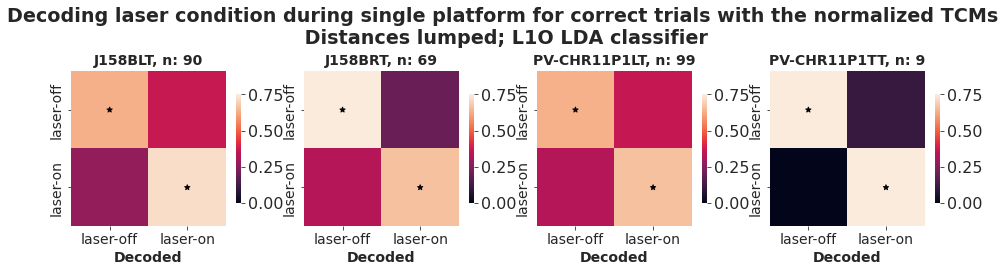

In [96]:
classifier = 'LDA'
method='L1O'
trial_types_labels = ['laser-off','laser-on']
s = 1
p = 1
fig, axes = plt.subplots(1,4,figsize=(16,4))

plt.suptitle('Decoding laser condition during single platform for correct trials with the normalized TCMs\n Distances lumped; {} {} classifier'.format(method,classifier),y=0.995)

for ii, mID in enumerate(mouse_IDs):


    ##Can we decode monocular vs binocular success trials within the same mouse/distance?
    indy_dict = base_df.groupby(['subject','trial_type','distance','success']).indices

    #What is the minimum # of trials between these conditions
    
    #Get trial indices
    indy_list = []
    nTrials_match = []
    for d in distances:
        for p in range(1,4):

                
            if ((mID,trial_types[0],d,s) not in indy_dict.keys()) | ((mID,trial_types[1],d,s) not in indy_dict.keys()):
                continue
            nTrials_match = np.min([len(indy_dict[(mID,c,d,s)]) for c in trial_types])
            for c in trial_types:
                indy_tmp = indy_dict[(mID,c,d,s)].copy()
                #Take random subset of trials to match # of nTrials_match
                np.random.shuffle(indy_tmp)
                indy_list.append(indy_tmp[:nTrials_match])

    trial_indices = np.concatenate(indy_list)
#     pdb.set_trace()
    
    #Create predictors and labels
    X = TCMs[trial_indices].reshape(len(trial_indices),-1)
    Y = np.array(base_df.iloc[trial_indices]['trial_type'])
    Y_sort = np.array(['{}_{}_{}'.format(base_df.iloc[iT]['trial_type'],base_df.iloc[iT]['platform'],base_df.iloc[iT]['distance']) for iT in trial_indices])
#         print(np.unique(Y_sort,return_counts=True))
    _,nTrials_match = np.unique(Y,return_counts=True)
    print(f'{nTrials_match} trials matched')
#     pdb.set_trace()
    # decoding analysis
    confusion_mat, confusion_shf, confusion_z, decoding_weights, decoding_weights_z = dc.cross_validate(X,Y,Y_sort,clabels=trial_types,nKfold=5,classifier=classifier,method=method)

    #Plot decoding performance 
    title = '{}, n: {}'.format(mID,nTrials_match[0])
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=trial_types_labels,ax=axes[ii],title=title,annot=False,clims=[0,0.75])

plt.savefig('./plots/decoding2/btwlaser_dist-lump_normTCM_RIS_{}_{}.png'.format(method,classifier))

## Compare laser-on vs laser-off trials during single & variable platform condition 

do it per distance
only success trials

In [97]:
### baseline (no opto) data & no RIS data
base_df = df_all.copy()
base_df = base_df[base_df['ocular']=='monocular']
base_df.reset_index(inplace=True,drop=True)

base_df['ptype'] = 'variable'
base_df.loc[(base_df['condition']=='RIS opto suture'), 'ptype'] = 'single'


trial_type = []
for index,row in base_df.iterrows():
    laser_str = row['laser_trial']
    laser_str = laser_str.replace(' ','-')
    trial_type.append('{}_{}'.format(row['ptype'],laser_str))

base_df['trial_type'] = trial_type
for key in base_df.keys():
    if ('Side' in key) | ('Top' in key):
        del base_df[key]
        
base_df

,index,expdate,subject,condition,platform,distance,jumpdist,success,laser_trial,jump_time,trial,fps,ocular,trMAPs,trPosteriors,trMasks,ptype,trial_type
0,2971,071820,J157BLT,suture,3,8,10.317914,1,laser off,311,1,60,monocular,"[3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, ...","[[1.9802110175678525e-05, 0.15098861098594712,...","[False, False, False, True, True, True, False,...",variable,variable_laser-off
1,2972,071820,J157BLT,suture,2,12,12.731243,1,laser off,463,2,60,monocular,"[2, 2, 2, 2, 4, 4, 4, 4, 4, 3, 3, 3, 1, 1, 2, ...","[[0.00023141538403836318, 0.3507282915116824, ...","[False, True, True, True, True, True, True, Tr...",variable,variable_laser-off
2,2973,071820,J157BLT,suture,2,8,10.132664,1,laser off,562,3,60,monocular,"[3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, ...","[[0.003128414461116978, 0.16633028987103568, 0...","[False, False, False, True, True, True, True, ...",variable,variable_laser-off
3,2974,071820,J157BLT,suture,2,16,9.752289,0,laser off,690,4,60,monocular,"[2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 2, 2, 2, ...","[[9.208680662875985e-05, 0.3134103604623716, 0...","[False, True, True, True, True, True, True, Tr...",variable,variable_laser-off
4,2975,071820,J157BLT,suture,3,12,13.253958,1,laser off,732,5,60,monocular,"[4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 3, 3, 3, ...","[[0.00033799273430716776, 0.06965128190882267,...","[False, True, True, True, True, True, True, Tr...",variable,variable_laser-off
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,2049,022021,PV-CHR11P1TT,RIS opto suture,1,16,1.785380,2,laser on,2245,17,60,monocular,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.02169507706013078, 0.15939725425781742, 0....","[True, True, True, True, True, True, True, Tru...",single,single_laser-on
1743,2050,022021,PV-CHR11P1TT,RIS opto suture,1,12,7.960352,1,laser off,2316,18,60,monocular,"[4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.0003369380044915807, 0.0721177435000796, 0...","[False, False, False, False, True, True, True,...",single,single_laser-off
1744,2051,022021,PV-CHR11P1TT,RIS opto suture,1,20,-0.221527,2,laser on,2445,19,60,monocular,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, ...","[[0.02164068453062073, 0.15940283856105356, 0....","[True, True, True, True, True, True, True, Tru...",single,single_laser-on
1745,2052,022021,PV-CHR11P1TT,RIS opto suture,1,24,10.853192,2,laser off,2563,20,60,monocular,"[5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.9083868263489697, 0.06668698869633627, 1.6...","[False, False, False, False, False, True, True...",single,single_laser-off


In [98]:
trial_types = np.unique(trial_type)
trial_types

array(['single_laser-off', 'single_laser-on', 'variable_laser-off',
       'variable_laser-on'], dtype='<U18')

In [99]:
lexical_TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=True)
TCMs = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=True,lexical=False)
TCMs_unnormalized = util.get_transition_count_matrices(list(base_df['trMAPs']),list(base_df['trMasks']),K,normalize=False,lexical=False)

TPM = np.exp(arhmm_params['transitions']['log_Ps'])


## Calculate state duration and state usage 
state_duration_list, state_startend_list, mean_state_durations, state_usage_pertrial, state_usage = util.get_state_durations(list(base_df['trMAPs']),list(base_df['trMasks']), K)

/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[81 81 81 81] trials matched
[60 60 60 60] trials matched
[54 54 54 54] trials matched
[9 9 9 9] trials matched


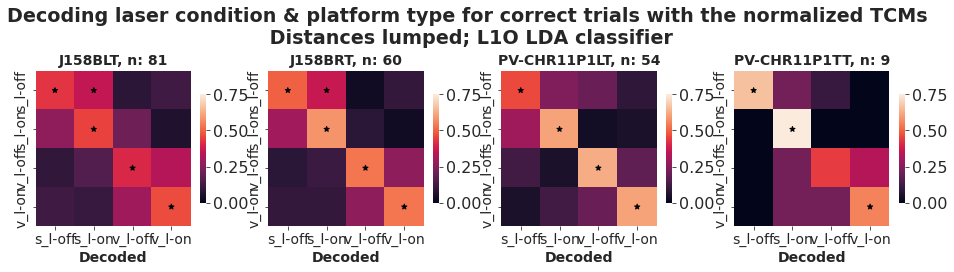

In [102]:
classifier = 'LDA'
method='L1O'

s = 1
p = 1
fig, axes = plt.subplots(1,4,figsize=(16,4))

plt.suptitle('Decoding laser condition & platform type for correct trials with the normalized TCMs\n Distances lumped; {} {} classifier'.format(method,classifier),y=0.995)

for ii, mID in enumerate(mouse_IDs):


    ##Can we decode monocular vs binocular success trials within the same mouse/distance?
    indy_dict = base_df.groupby(['subject','trial_type','distance','success']).indices

    #What is the minimum # of trials between these conditions
    
    #Get trial indices
    indy_list = []
    nTrials_match = []
    for d in distances:
        for p in range(1,4):

                
            if ((mID,trial_types[0],d,s) not in indy_dict.keys()) | ((mID,trial_types[1],d,s) not in indy_dict.keys()) | ((mID,trial_types[2],d,s) not in indy_dict.keys()) | ((mID,trial_types[3],d,s) not in indy_dict.keys()):
                continue
            nTrials_match = np.min([len(indy_dict[(mID,c,d,s)]) for c in trial_types])
            for c in trial_types:
                indy_tmp = indy_dict[(mID,c,d,s)].copy()
                #Take random subset of trials to match # of nTrials_match
                np.random.shuffle(indy_tmp)
                indy_list.append(indy_tmp[:nTrials_match])

    trial_indices = np.concatenate(indy_list)
#     pdb.set_trace()
    
    #Create predictors and labels
    X = TCMs[trial_indices].reshape(len(trial_indices),-1)
    Y = np.array(base_df.iloc[trial_indices]['trial_type'])
    Y_sort = np.array(['{}_{}_{}'.format(base_df.iloc[iT]['trial_type'],base_df.iloc[iT]['platform'],base_df.iloc[iT]['distance']) for iT in trial_indices])
#         print(np.unique(Y_sort,return_counts=True))
    _,nTrials_match = np.unique(Y,return_counts=True)
    print(f'{nTrials_match} trials matched')
#     pdb.set_trace()
    # decoding analysis
    confusion_mat, confusion_shf, confusion_z, decoding_weights, decoding_weights_z = dc.cross_validate(X,Y,Y_sort,clabels=trial_types,nKfold=5,classifier=classifier,method=method)

    #Plot decoding performance 
    title = '{}, n: {}'.format(mID,nTrials_match[0])
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=trial_types_labels,ax=axes[ii],title=title,annot=False,clims=[0,0.75])

plt.savefig('./plots/decoding2/btwlaser-and-ptype_dist-lump_normTCM_{}_{}.pdf'.format(method,classifier))

In [113]:
trial_types

array(['single_laser-off', 'single_laser-on', 'variable_laser-off',
       'variable_laser-on'], dtype='<U18')

In [101]:
trial_types_labels = ['s_l-off','s_l-on','v_l-off','v_l-on']